# Exercise Sheet 5: Electrodes Electronics

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bci_minitoolbox as bci
from scipy import signal as signal
import Exercise5_helper as helper
from music import *

## Task 1: noise & signal models (4 points)
Simulate and plot noise & a simple alpha-oscillation model on a timescale of $5s$ with a sampling frequency of $1kHz$.

a) Generate a function *noise_w* that implements gaussian white noise with the variance $\sigma_n$ as an input parameter. White noise can be simply generated using np.random functions and the gaussian one would use the np.random.normal or np.random.randn.

b) Use the white noise function to produce pink noise (1/f) *noise_p* by frequency filtering it in the spectral domain. Therefor do a fourier transformation (np.fft.rfft) of the white noise, get the corresponding frequencies (np.fft.rfftfreq) and then multiply the fourier transfromed signal by $\frac{1}{f}$ (the factor $\frac{1}{f^2}$ is defined in the power spectrum which leads to $\sqrt{\frac{1}{f^2}}=\frac{1}{f}$ in the amplitude spectrum). As the DC part ($f=0$) would lead to a division by zero, you can simply divide the coresponding fft value by 1 instead.
Then transform the signal back to time domain (np.fft.irfft).

c) Do the same as for the pink noise to generate a simulated alpha oscillation *x_alpha* by tranformation of white noise to the frequency domain, spectral filtering and then transformation back to the time domain. For the shape in the frequency domain, use a peak function similar to that found in EEG.  A gaussian peak from 8 to 13 Hz with a standard deviation of $\frac{1}{10}$ of it's window (8-13Hz) width and the function *scipy.signal.gaussian(N,std)* as an approximation to the peak of an alpha oscillation in the frequency spectrum or similar is sufficient.

Plot all three noise & signal models into one plot first in the time domain and then in a secon plot in the frequency domain^(PSD with welch algorithm).

In [2]:
fs = 1000
time = 5
size = time * fs # 5000
t = np.linspace(0,time,size)

### a) nosie_w

In [3]:
sigma = 0.01
def noise_w(sigma,size): 
    w = np.random.normal(0,sigma,size)  
    return w
# time
n = noise_w(sigma,size)
# freq
f = np.fft.rfft(n, axis=0)

### b) nosie_p

In [4]:
# white noise corresponding freq
frq = np.fft.rfftfreq(size, 1/fs)
frq[0]=1
# pink freq
noise_p_f = f.T / frq
# pink time
noise_p = np.fft.irfft(noise_p_f)

### c)

In [5]:
index = (frq >= 8) & (frq < 13)
g = np.zeros(len(frq))
g[index] = signal.gaussian(np.sum(index),np.sum(index)/10)  
alpha_f = g * f
x_alpha = np.fft.irfft(alpha_f)

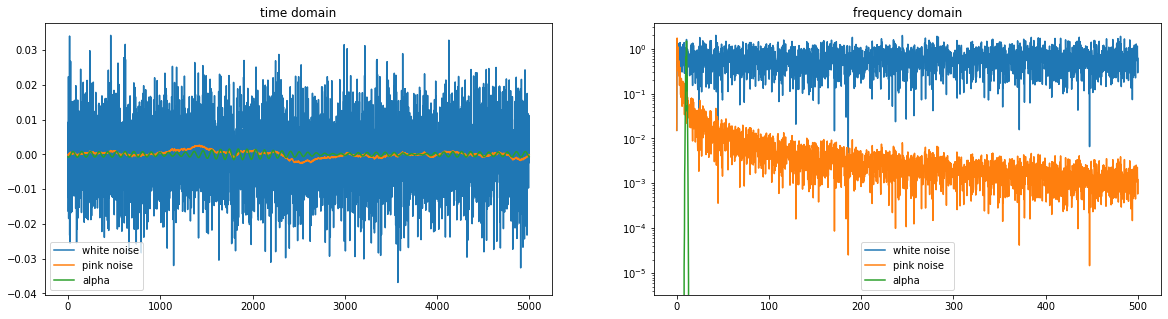

In [6]:
frq = np.fft.rfftfreq(size, 1/fs)
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('time domain')
ax[0].plot(n,label = 'white noise')
ax[0].plot(noise_p,label = 'pink noise')
ax[0].plot(x_alpha,label = 'alpha')
ax[0].legend()

ax[1].set_title('frequency domain')
ax[1].semilogy(frq, np.abs(f),label = 'white noise')
ax[1].semilogy(frq, np.abs(noise_p_f) ,label = 'pink noise')
ax[1].semilogy(frq, np.abs(alpha_f),label = 'alpha')
ax[1].legend()

# ax[2].set_title('power spectrum')
# f_white, p1 = signal.welch(n, 1000)
# f_pink,  p2 = signal.welch(noise_p, 1000)
# f_alpha, p3 = signal.welch(x_alpha, 1000)
# ax[2].semilogy(f_white, p1,label = 'white noise')
# ax[2].semilogy(f_pink,  p2,label = 'pink noise')
# ax[2].semilogy(f_alpha, p3,label = 'alpha')
# ax[2].legend()

plt.show()

## Task 2 EEG simulation (4 points)

a) Generate a signal 

$v(t)=\alpha_s s(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$, 

where $s(t)$ is the simulation an alpha osicllation *s_alpha*, $w_n$ is white noise and $p_n$ is pink noise. The $\alpha$s are the corresponding weights to account for individual signal powers. Plot the time course for a single channel of length $5s$ with a sampling frequency of 1kHz. Do a frequency transformation using the fourier transform and plot the power spectrum. Tune your weights $\alpha$ to get a roughly EEG-like spectrum.

b) Use the leadfield of one dipole of your choice (without amplifier input impedance) and simulate the scalp potential $v$ of an alpha oscillation in that source *s* by multiplying it with the leadfield $x(t)=L_i^T s(t)$. You can also load the scalp pattern produced by dipole $i=2081$ in $p=[0, \sqrt[]\frac{2}{3}, \sqrt[]\frac{1}{3} ]^T$ saved in 'patternDip2081.npy' to avoid the calculations. Plot the time course for channels Cz and Oz into one plot. Also, plot the power spectrum for the two channels. You can find the channel index in the variable  'clab.npy'.

c) Repeat task a) but this time use the scalp potential $x(t)$ produced in b) to simulate an EEG alpha oscillation. Add the noise independently to each channel allthough this might not be fully realistic.

$v(t)=x(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$

Again, plot the time course and the power spectrum for channels Cz and Oz.

d) Use the scalpmap function of the BBCI minitoolbox to plot the scalp pattern of the 10 Hz component in the fourier transform of the signal of task c) and compare it to the plain scalp pattern of that source. To extract the pattern, simply take the values at the peak (f==10Hz). This can be mutliplied with the source activity.

*Hint: You can use the exercise5_helper if you haven't succeeded with task 1!*

### a)

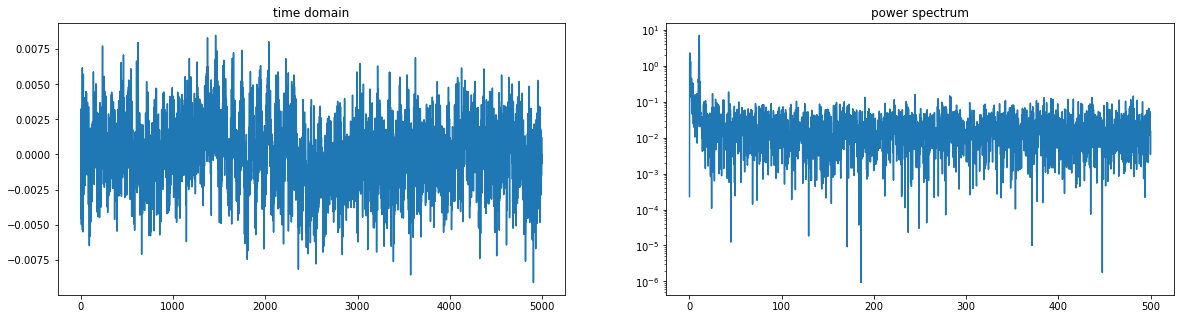

In [7]:
a_s = 1.5
a_w = 0.2
a_p = 0.8
size = 5 * 1000 # time*sampling rate

v = a_s*x_alpha + a_w*n + a_p*noise_p

vf=np.fft.rfft(v) # fourier transform v

fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('time domain')
ax[0].plot(v)

ax[1].set_title('power spectrum')
ax[1].semilogy(frq, np.square(np.abs(vf))) # power spectrum=(abs(fft))**2
# vff, vp = signal.welch(v, 1000)  # directly using signal.welch, same shape
# ax[1].semilogy(vff, vp.T*10e6)

plt.show()

### b)

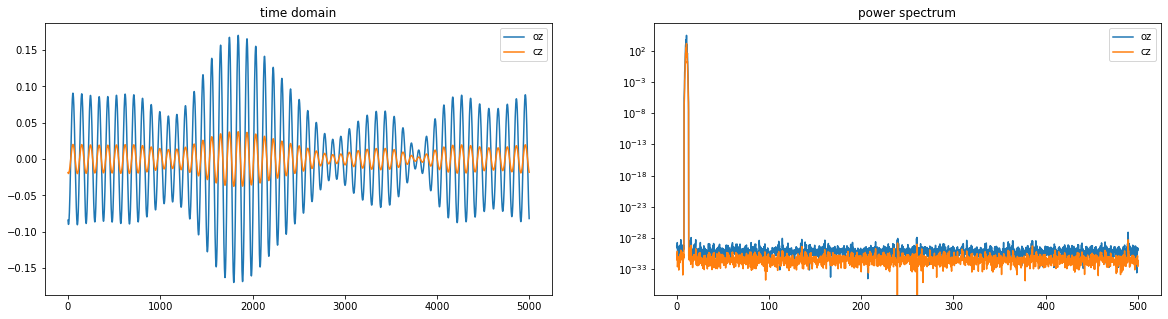

In [8]:
dip = np.load('patternDip2081.npy') #72*1
clab=np.load('clab.npy') #72 channel

cz = np.argwhere(clab == 'Cz').item()
oz = np.argwhere(clab == 'Oz').item()

x_alpha = x_alpha.reshape(1, 5000)
x_t = np.dot(dip, x_alpha)
x_tf = np.fft.rfft(x_t)

Cz = x_t[cz]
Oz = x_t[oz]

Czf = x_tf[cz]
Ozf = x_tf[oz]

fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('time domain')
ax[0].plot(Oz, label="oz")
ax[0].plot(Cz, label="cz")
ax[0].legend()

ax[1].set_title('power spectrum')
ax[1].semilogy(frq, np.square(np.abs(Ozf)), label="oz") 
ax[1].semilogy(frq, np.square(np.abs(Czf)), label="cz")
ax[1].legend()

plt.show()

### c)

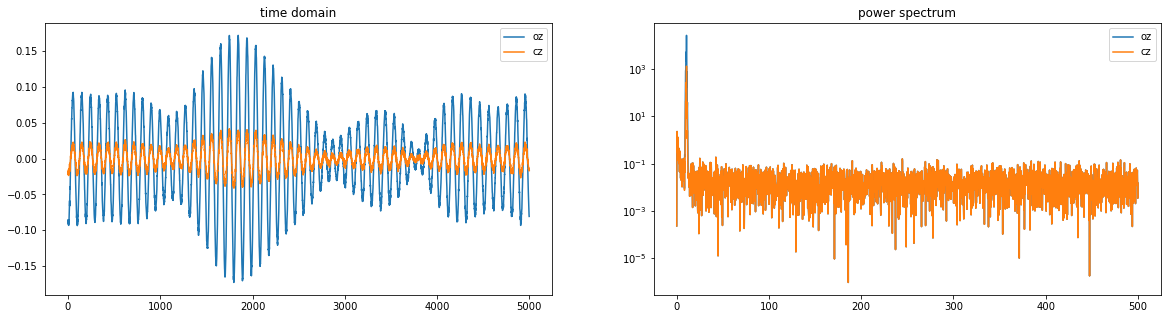

In [9]:
v_new = x_t + a_w*n + a_p*noise_p
v_new_f = np.fft.rfft(v_new)

v_cz = v_new[cz]
vf_cz = v_new_f[cz]

v_oz = v_new[oz]
vf_oz = v_new_f[oz]

fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('time domain')
ax[0].plot(v_oz, label="oz")
ax[0].plot(v_cz, label="cz")
ax[0].legend()

ax[1].set_title('power spectrum')
ax[1].semilogy(frq, np.square(np.abs(vf_oz)), label="oz")
ax[1].semilogy(frq, np.square(np.abs(vf_cz)), label="cz")
ax[1].legend()

plt.show()

### d)

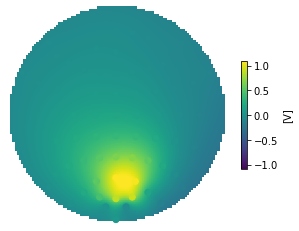

In [10]:
mnt = np.load('mnt.npy') #72*2

index = np.argwhere(frq == 10).item()
phi = v_new[:,index]*10

bci.scalpmap(mnt, phi, clim='sym', cb_label='[V]')
plt.show()

## Task 3: The MUSIC algorithm (3 points)
In EEG source reconstruction one of the most straight-forward approaches is to estimate the most probable source of a signal by finding the closest possible soulution to measured scalp potentials from a discrete set of dipoles. To this extent, the leadfield $L$ with dimensions NoChannels x NoDipoles x 3 is used for every dipole location to approximate the measured potential $v$ and then the closest mostly in a $L_2$ norm is expected to be the most probable source.

Luckily, the MUSIC algorithm does that for you and you have the function provided. The function returns the most probable source location index imax, it's potential vmax it produces along with the orientation/moment of the optimal dipole dip_mom and other parameters.

The true source ID is 2499.

There are EEG simulations of two different noise levels in the files "alphascalphighSNR.npy" and "alphascalplowSNR.npy". The true source without noise can be simulated by v_sim=L[:,iDip,:], where *iDip* is the true source ID 2499. You need to accord for the right orientation using the dotproduct with gridnorm[:,iDip].

** Tasks:**

a)  Determine the index of the dipole with minimum amplitude error for each noise level in the simualted potentials *v_sim* for each of the noise levels ( v_sim = no noise, v_sim_noiseL = low noise, v_sim_noiseH = high noise). Use the music algorithm and also calculate the localization error as the Euclidean distance between the source found (dip_loc) and the real position of the source (the right entry of gridpos).

b) Investigate the simulated scalp potentials *v_sim* with the *bci.scalpmap* function of the bci_minitoolbox and try to explain the different results in source localization.

c) Load the scalp pattern *alphascalp.npy* which originates in real EEG data taken from a motor imagery experiment. The PSD values where tansformed to amplitudes (square root) and normalized. Find the best matching source location using the music function, but this time search in the leafield *leadfield_relab.npy* that is relabeled to the different set of electrodes in the real data. Also, plot the scalmaps of the *alphascalp.npy* and compare it to the one of the dipole found. What's the difference? What could be the reason for this?

### a)

In [36]:
L=np.load('leadfield3dim.npy')  #72*3990*3
gridpos=np.load('gridpos.npy')  # 3990*3 , source position
gridnorms=np.load('gridnorms.npy')  # 3*3990
v_sim_noiseL=np.load('alphascalphighSNR.npy')  # 72*1
v_sim_noiseH=np.load('alphascalplowSNR.npy')   # 72*1

v_sim=L[:,2499,1]
result_0 = music(v_sim, L, gridpos)
source0 = result_0[2] # 2499
result_L = music(v_sim_noiseL, L, gridpos)
sourceL=result_L[2] # 2500
result_H = music(v_sim_noiseH, L, gridpos)
sourceH=result_H[2] # 2178

print("The estimated index of dipole \n no noise:\t %d \n low noise:\t %d \n high noise:\t %d"%(source0, sourceL, sourceH))

The estimated index of dipole 
 no noise:	 2499 
 low noise:	 2500 
 high noise:	 2178


In [30]:
L.shape

(72, 3990, 3)

In [34]:
gridnorms.reshape(3,3990,1).shape

(3, 3990, 1)

In [12]:
L[:,2499,1].shape

(72,)

### b)

no noise


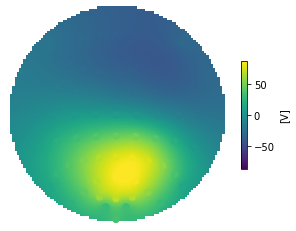

In [13]:
bci.scalpmap(mnt, L[:,2499,1], clim='sym', cb_label='[V]')
print('no noise')
plt.show()

low noise


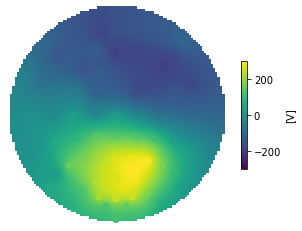

In [14]:
bci.scalpmap(mnt, v_sim_noiseL, clim='sym', cb_label='[V]')
print('low noise')
plt.show()

high noise


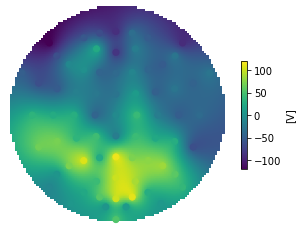

In [15]:
bci.scalpmap(mnt, v_sim_noiseH, clim='sym', cb_label='[V]')
print('high noise')
plt.show()

In [16]:
# the different results in source localization:
# From no_noise to low_noise and high_noise, the scalpmap is getting more rough and the source is less identical.
# Reason: the higher noise, the source's power density is less well distributed. Source points get more reandom values.

### c)

In [17]:
L_relab=np.load('leadfield3dimrelab.npy') #51,3990,3
alphascalp=np.load('alphascalp.npy') # 51,
mnt_alpha=np.load('mnt_alphascalp.npy')

In [18]:
result = music(alphascalp, L_relab, gridpos)
source = result[2]
source

2889

the true scalmap


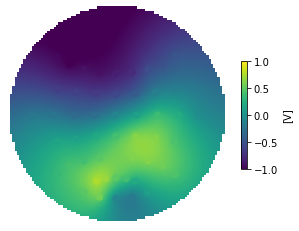

In [19]:
print('the true scalmap')
bci.scalpmap(mnt_alpha, alphascalp, clim='sym', cb_label='[V]')

the scalmap with the estimated source


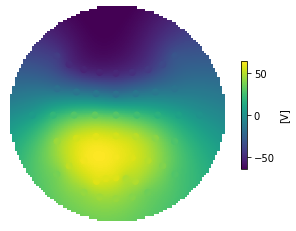

In [20]:
print('the scalmap with the estimated source')
bci.scalpmap(mnt_alpha, L_relab[:,source,1], clim='sym', cb_label='[V]')

In [21]:
# difference & reasons:
# When people conduct motor imaginary methods, there will be random noise or surrounded source will be activated. 
# Besides, there are environmental noise which lead the result more fuzzy.

## Task 4: LCMV - (4 points)

The linear constraint minimum variance algorithm uses a mixture of the head model information for a region of interest (ROI) at location $r_q$ and the signal covairance to extract filters that minimize the effect among sources while leading to a unit response for the source of interest.
The array of filters can be calculated by:

$W_i^T=[L_i^T C_x^{-1} L_i]^{-1}L_i^T C_x^{-1}$

a) Implement the LMCV algorithm for a given leadfield $L$ and the signal covariance $C_x$. The output should be the spatial filter matrix $W$ consisting of the filters for all sources of L.

b) Calculate the spatial filter matrix for the dataset given in 'imagVPaw.npz' and the leadfield matrix from 'leadfield_relab.npy'.

c) Reconstruct the source estimated in task 3 c) from 'alphascalp.npy' and plot the PSD in decibel using the welch algorithm. *If you did not succeed with task 3, use source number 2499.*

In [22]:
def LMCV(L,C):
    A = L.T@np.linalg.inv(C)@L
    WT = np.linalg.inv(A)@L.T@np.linalg.inv(C)
    return WT.T

In [23]:
imagVPaw=np.load('imagVPaw.npz') 
L_relab=np.load('leadfield3dimrelab.npy') #(51, 3990, 3)

In [24]:
fs_ = imagVPaw['fs'].item() # fs=100
mnt_ = imagVPaw['mnt'] # 51,2
X = imagVPaw['X'] # 51,282838

In [25]:
W = LMCV(L_relab[:,:,1], np.cov(X))

In [26]:
W.shape

(51, 3990)